In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import math

from PlottingFunctions import *

from ControlChartsModule import *


In [2]:
jm_colors_dict = {
    'JM Blue':'#1e22aa',
    'JM Purple':'#e50075',
    'JM Cyan':'#00abe9','JM Green':'#9dd3cb',
    'JM Magenta':'#e3e3e3',
    'JM Light Grey':'#575756',
    'JM Dark Grey':'#6e358b'
}
jm_colors_list = list(jm_colors_dict.values())
marker_list = ["o","v","D","x","X","<","8","s","^","p","P","*","h","H","+","d","|","_"]

jm_colors_list = list(jm_colors_dict.values())
cb_colors_list = sns.color_palette("muted")+sns.color_palette("muted")  # deep, muted, pastel, bright, dark, and colorblind
hls_colors_list = sns.color_palette("hls", 8) + sns.color_palette("hls", 8)
tab10_colors_list = sns.color_palette("tab10") + sns.color_palette("tab10")


In [3]:
#%% Data Import, Exploration and Cleaning
batch_path = "C:/Users/JacksC01/OneDrive - Johnson Matthey/Documents/PPI/Data"
df_raw = read_data(batch_path,
         "AugerMassDosing.xlsx",
                   tab_name = "Auger Mass Dosing", skip_r = 0)

fig_titles = "AugerDosing"

# print(df_raw.shape)
# print(df_raw.info())
# print(df_raw.describe())
print(f"Columns:\n{df_raw.columns.to_list()}")

df_raw.Delete.fillna(False, inplace = True)

df = df_raw.loc[df_raw["Delete"] == False]
df.dropna(subset = ["Powder mass"], inplace = True)
df.rename(columns = {'Powder mass':"Shot Mass (g)"}, inplace = True)
df["Date"] = pd.to_datetime(df["Date"], dayfirst = True).dt.date

df = df.sort_values(by=['Date',"Nest",'Sample Number'], ascending=True) # "Nest No.",
df.Overflight.fillna(0, inplace = True)
df["Overflight"] = df["Overflight"].map({1: "True",0:"False"})

df.Material.fillna("Alu130", inplace = True)

df.Nest.fillna(1, inplace = True)
df.Nest = df.Nest.astype(int)

df[["Nest","Auger","Funnel"]] = df[["Nest","Auger","Funnel"]].astype(str)
                       
df["Nest/Aug/Fun"] = df["Nest"] +"/"+ df["Auger"] + "/" + df["Funnel"]
df["Nest/OF"] = df["Nest"] +"/"+ str(df["Overflight"])

df["Dosing Rate (g/rev)"] = df["Shot Mass (g)"] / df["Revs"]

df["System"] = np.where(df.Rig == "Pilot Line", df.Rig + " - Nest " + df.Nest.astype(str), df.Rig)

print(df.System.unique())
print(df.isna().sum())

Columns:
['Trial Name', 'Rig', 'Sample Number', 'Beaker Label', 'Powder mass', 'Delete', 'Auger Temperature', 'Date', 'Powder Batch', 'Material', 'RPM', 'Comments', 'Nest', 'Auger', 'Funnel', 'Overflight', 'Revs']
['Pilot Line - Nest 1' 'Dev Rig' 'Pilot Line - Nest 2' 'All-Fill']
Trial Name             250
Rig                      0
Sample Number            0
Beaker Label           200
Shot Mass (g)            0
Delete                   0
Auger Temperature      800
Date                     0
Powder Batch           800
Material                 0
RPM                    293
Comments               900
Nest                     0
Auger                    0
Funnel                   0
Overflight               0
Revs                     0
Nest/Aug/Fun             0
Nest/OF                  0
Dosing Rate (g/rev)      0
System                   0
dtype: int64


C:\Users\JacksC01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\JacksC01\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\JacksC01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

C:\Users\JacksC01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


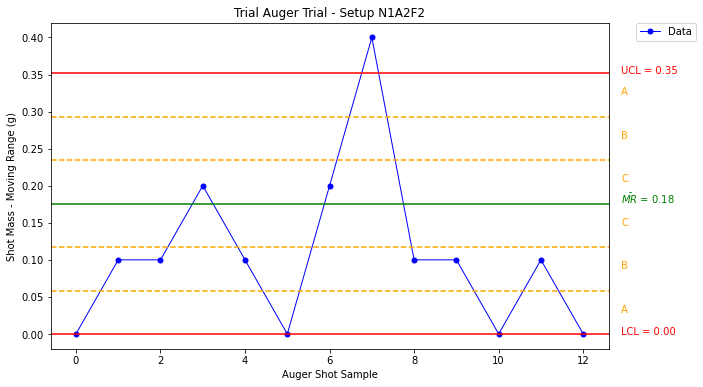

Applying Test 1: One point at 3 std dev or more...
Test 1 failed
Alarm at  35.90,  36.00,  36.00,  36.60,  36.60,  36.60.
-----
Applying Test 2: Nine points in a row on the same side of the mean...
Test 2 passed.
-----
Applying Test 3: Six points trending in the same direction...
Test 3 passed.
-----
bad index: 9.0
bad index: 3.0
bad index: 4.0
bad index: 7.0
Test 1: 6 signals
Test 2: 0 signals
Test 3: 0 signals


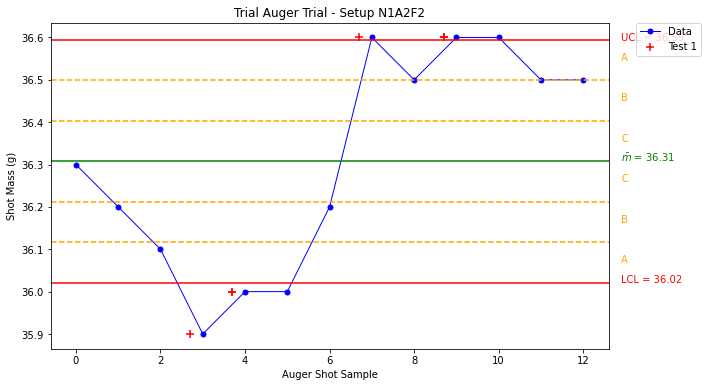

In [4]:
# for setup in df["Rig/Aug/Fun"].unique():
setup = "1/2/2" # df["Nest/Aug/Fun"].unique()
df_all = df.loc[df["Nest/Aug/Fun"]==setup]
setup_stddev = np.std(df_all["Shot Mass (g)"], ddof = 0) # divisor = n-1
control_tests = [1,2,3]

# print(f"""
# ----------------------
# Setup (Nest/Aug/Fun): {setup}
# {df_all["Shot Mass (g)"].describe()}""")

trials = df_all["Trial Name"].unique()
for trial in trials[:1]:

    df_sample = df_all.loc[df_all["Trial Name"] == trial]
    df_sample.reset_index(inplace = True)
    df_sample["Index"] = df_sample.index
    max_date = df_sample.Date.max()

    nest = df_sample.Nest.mode().values[0]
    auger = df_sample.Auger.mode().values[0]
    funnel = df_sample.Funnel.mode().values[0]

    # sample dataset
    df_sample_data = df_sample[["Shot Mass (g)","Index"]]
    
    # print(df_sample_data.head(3))
    
    sample_data = np.array(df_sample_data).T # [[value, index]]
    # print(sample_data[:,0]) # all rows, first column
    
    # plotting
    title = "Trial {0} - Setup N{1}A{2}F{3}".format(trial.strip(), nest, auger, funnel)
    figure_name = "ControlChart_{0}_N{1}A{2}F{3}".format(trial.replace(" ",""), nest, auger, funnel)
    
    ControlChart.mr_graph(sample_data.T, x_string = 'Auger Shot Sample', y_string = 'Shot Mass - Moving Range (g)',
                               title_string = title, fig_name = figure_name+"_MR")
    
    ControlChart.control_graph(sample_data.T, setup_stddev, x_string = 'Auger Shot Sample', y_string = 'Shot Mass (g)',
                               p_control_tests = control_tests,
                               title_string = title, fig_name = figure_name+"_I", y_lim = None)




In [5]:
# D3 - D4 lower - uppder control limit constants
# absolute MR
# mr chart first

# .1 sigma shift would take 10000s

# x bar t chart (central limit theorem)
# I-MR chart is single points
# UCL is equidistant from xbar as LCL

# print("Assuming normal distribution, hence 99.73% of observations are with +-3 std dev of the mean...\n")
# Q-Q plot|Freq distribution|Normality test
# (shapiro-wilk test): small p -> accept null hypothesis that it is normal

#%% swarm plot of shot mass as func of nest, funnel, auger
# def sns_swarm(dataFrame, x_label, y_label, color_var, 
#         hue_label = None, col_label = None,  orient_var = "v",
#         fig_name_var = None, legend_var = False, axis_lim = None, title_var = None):
    
#     ax = sns.catplot(x = x_label, y = y_label, data = dataFrame, hue = hue_label, col = col_label,
#                          dodge = False, kind = "violin",
#                          palette = color_var, orient = orient_var,
#                          legend = False) # linewidth = 1., edgecolor = "black",
    
#     ax.fig.set_size_inches(10,8)
    
    
#     if axis_lim and orient_var == "v":
#         plt.ylim(axis_lim[0], axis_lim[1])
    
#     elif axis_lim:
#         plt.xlim(axis_lim[0], axis_lim[1])
        
#     if legend_var == True:
#         plt.legend(title = hue_label, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     else:
#         plt.legend([],[], frameon=False)
    
#     if title_var:
#         plt.title(title_var)
    
#     plt.tight_layout()
    
#     if fig_name_var:
#         plt.savefig(fig_name_var+".png", facecolor='w')

#     plt.show()

# sns_swarm(df, "Shot Mass (g)", "Nest", jm_colors_list[:], 
#         hue_label = "Auger", col_label = "Funnel",  orient_var = "h",
#         fig_name_var = "AugerShotTest_Violin", legend_var = True, axis_lim = None, title_var = None)

#%% correlation plot
# correlation check of a/n/f
# corrMatrix_all = df.corr()
# features = ["Final BP (mBar)",'Dosing Time (s)']
# corr_limit_val = 0.4
# corrMatrix = corrMatrix_all[features]
# filteredDf = corrMatrix[(corrMatrix.abs() >= corr_limit_val) & (corrMatrix.abs() !=1.000)]
# filteredDf.dropna(how = "all", inplace = True)
# plt.figure(figsize=(10,10))
# sns.heatmap(filteredDf, annot=True, cmap="Reds")
# plt.show()